<a href="https://colab.research.google.com/github/taekjunkim/artiphysiology2020/blob/main/get_Alexnet_center_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

stim_path ='/content/gdrive/My Drive/UW_PasupathyLab/ShortTermWork/Artiphysiology2020/Animal_Icons/stims/'

import os
os.chdir(stim_path+'class01')
!ls

os.chdir('/content/')
!pwd

Mounted at /content/gdrive
stim0100.png  stim0120.png  stim0140.png  stim0160.png	stim0180.png
stim0101.png  stim0121.png  stim0141.png  stim0161.png	stim0181.png
stim0102.png  stim0122.png  stim0142.png  stim0162.png	stim0182.png
stim0103.png  stim0123.png  stim0143.png  stim0163.png	stim0183.png
stim0104.png  stim0124.png  stim0144.png  stim0164.png	stim0184.png
stim0105.png  stim0125.png  stim0145.png  stim0165.png	stim0185.png
stim0106.png  stim0126.png  stim0146.png  stim0166.png	stim0186.png
stim0107.png  stim0127.png  stim0147.png  stim0167.png	stim0187.png
stim0108.png  stim0128.png  stim0148.png  stim0168.png	stim0188.png
stim0109.png  stim0129.png  stim0149.png  stim0169.png	stim0189.png
stim0110.png  stim0130.png  stim0150.png  stim0170.png	stim0190.png
stim0111.png  stim0131.png  stim0151.png  stim0171.png	stim0191.png
stim0112.png  stim0132.png  stim0152.png  stim0172.png	stim0192.png
stim0113.png  stim0133.png  stim0153.png  stim0173.png	stim0193.png
stim0114.png  stim013

In [ ]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.get_device_name(0)    
else:
    device = torch.device("cpu")

import torchvision.models as models

import numpy as np;

import torch.nn as nn

import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [ ]:
# Comment 0: define transformation that you wish to apply on image
data_transforms = transforms.Compose(
    #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] 
    #to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] 
    #if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1)
    # or if the numpy.ndarray has dtype = np.uint8
    [transforms.ToTensor(),
     #normalization of pre-trained networks:
     #from docs:
     #All pre-trained models expect input images normalized in the same way, 
     #i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where
     #H and W are expected to be at least 224. The images have to be loaded 
     #in to a range of [0, 1] and then normalized using 
     #mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. 
     transforms.Normalize([0.485, 0.456, 0.406], 
                          [0.229, 0.224, 0.225])])#

# Comment 1 : Load the datasets with ImageFolder
image_datasets = datasets.ImageFolder(root= stim_path, transform=data_transforms)
# Comment 2: Using the image datasets and the transforms, define the dataloaders
dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=10, shuffle=False, num_workers=2);

In [ ]:
print(image_datasets.imgs[2210])

('/content/gdrive/My Drive/UW_PasupathyLab/ShortTermWork/Artiphysiology2020/Animal_Icons/stims/class22/stim2210.png', 22)


In [ ]:
### verified that enumerate re-shuffles dataloader at every epochs, when shuffle=True
"""
for epochs in range(100):
    for i, (image,labels) in enumerate(dataloaders):
        print(i, labels);
"""

'\nfor epochs in range(100):\n    for i, (image,labels) in enumerate(dataloaders):\n        print(i, labels);\n'

In [ ]:
import copy;

alexnet = models.alexnet(pretrained=True);
alexnet.eval();
alexnet.to(device)

layers_of_interest = [3,6,8,10]; # layers where RF size > 50 pix

outputs = []; #simple function to store outputs
def store_output(module,input,output):

    cPos = int(np.ceil(np.shape(output)[2]/2)-1);
    outputs.append(output[:,:,cPos,cPos]);


for i,layer in enumerate(alexnet.features):
    if i in layers_of_interest:
        print(layer)
        layer.register_forward_hook(store_output);
    if isinstance(layer, nn.ReLU):
        layer.inplace = False #set inplace rectification to False to get unrect responses        

"""
for name,m in alexnet.named_modules():
    str_name = str(name).split('.');
    if len(str_name)>1:
        layerNum = int(str_name[1]);
        if (layerNum in layers_of_interest) and (str_name[0]=='features'):
            m.register_forward_hook(store_output);
"""

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth



Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


"\nfor name,m in alexnet.named_modules():\n    str_name = str(name).split('.');\n    if len(str_name)>1:\n        layerNum = int(str_name[1]);\n        if (layerNum in layers_of_interest) and (str_name[0]=='features'):\n            m.register_forward_hook(store_output);\n"

In [ ]:
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=F

In [ ]:
alexnet_outputs = [];

for i, (images,labels) in enumerate(dataloaders):

    if torch.cuda.is_available():  
        images = images.cuda();
    #images = Variable(images.float());
    #Test input
    outputs = []; 
    out = alexnet(images)

    print('batch(size 10) # '+str(i)+' was processed')

    if torch.cuda.is_available():  
        for j in range(len(outputs)):
            outputs[j] = outputs[j].cpu();

    if i==0:
        alexnet_outputs = outputs;
        for j in range(len(outputs)):
            alexnet_outputs[j] = alexnet_outputs[j].detach().numpy();
    else:
        for j in range(len(outputs)):
            alexnet_outputs[j] = np.append(alexnet_outputs[j],outputs[j].detach().numpy(),axis=0);


batch(size 10) # 0 was processed
batch(size 10) # 1 was processed
batch(size 10) # 2 was processed
batch(size 10) # 3 was processed
batch(size 10) # 4 was processed
batch(size 10) # 5 was processed
batch(size 10) # 6 was processed
batch(size 10) # 7 was processed
batch(size 10) # 8 was processed
batch(size 10) # 9 was processed
batch(size 10) # 10 was processed
batch(size 10) # 11 was processed
batch(size 10) # 12 was processed
batch(size 10) # 13 was processed
batch(size 10) # 14 was processed
batch(size 10) # 15 was processed
batch(size 10) # 16 was processed
batch(size 10) # 17 was processed
batch(size 10) # 18 was processed
batch(size 10) # 19 was processed
batch(size 10) # 20 was processed
batch(size 10) # 21 was processed
batch(size 10) # 22 was processed
batch(size 10) # 23 was processed
batch(size 10) # 24 was processed
batch(size 10) # 25 was processed
batch(size 10) # 26 was processed
batch(size 10) # 27 was processed
batch(size 10) # 28 was processed
batch(size 10) # 29 was 

In [ ]:
print(np.shape(alexnet_outputs[0])) #conv2
print(np.shape(alexnet_outputs[1])) #conv3
print(np.shape(alexnet_outputs[2])) #conv4
print(np.shape(alexnet_outputs[3])) #conv5

(2211, 192)
(2211, 384)
(2211, 256)
(2211, 256)


In [ ]:
os.chdir(stim_path)
np.savez('alexnet_outputs.npz',conv2=alexnet_outputs[0],
                               conv3=alexnet_outputs[1],
                               conv4=alexnet_outputs[2],
                               conv5=alexnet_outputs[3]);

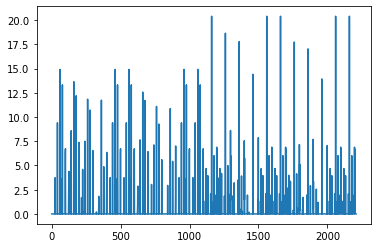

In [ ]:
data = np.load('alexnet_outputs1.npz');

import matplotlib.pyplot as plt;
plt.plot(data['conv2'][:,1].clip(min=0))

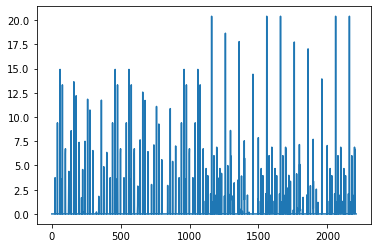

In [ ]:
data = np.load('alexnet_outputs.npz');

import matplotlib.pyplot as plt;
plt.plot(data['conv2'][:,1])

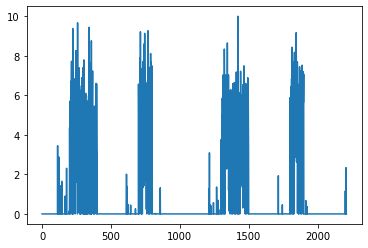

In [ ]:
import matplotlib.pyplot as plt;
plt.plot(alexnet_outputs[3][:,1])